In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# PRE-PROCESAMIENTO DEL DATASET:

# standard library imports
import itertools
import re

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

df_steam = pd.read_csv('/content/drive/MyDrive/MineriaDCC/steam.csv')

def remove_non_english(df):
    # keep only rows marked as supporting english
    df = df[df['english'] == 1].copy()

    # keep rows which don't contain 3 or more non-ascii characters in succession
    df = df[~df['name'].str.contains('[^\u0001-\u007F]{3,}')]

    # remove english column, now redundant
    df = df.drop('english', axis=1)

    return df

def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews

    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100

def calc_rating_label(row):
  """Calculate rating label based on normal rating."""
  rating = row['rating']

  # Divide el rango en 5 partes iguales
  bin_edges = [0, 20, 40, 60, 80, 100]
  labels = ["Muy Malo", "Malo", "Regular", "Bueno", "Muy Bueno"]

  # Asigna la etiqueta según el rango
  rating_label = pd.cut([rating], bins=bin_edges, labels=labels, include_lowest=True)[0]

  return rating_label

def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

def process_cat_gen_tag(df):
    """Process categories, genres and steamspy_tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['categories'])

    # only going to use these categories (can uncomment to use others)
    cat_cols = [
        # 'Local Multi-Player',
        # 'MMO',
        # 'Mods',
        'Multi-player',
        # 'Online Co-op',
        # 'Online Multi-Player',
        'Single-player'
    ]

    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)

        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)

    # repeat for genre column names (get_unique used to find unique genre names,
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['genres'])

    # only keeping 'main' genres similar to steam store
    gen_cols = [
        # 'Accounting',
        'Action',
        'Adventure',
        # 'Animation & Modeling',
        # 'Audio Production',
        'Casual',
        # 'Design & Illustration',
        # 'Documentary',
        # 'Early Access',
        # 'Education',
        # 'Free to Play',
        # 'Game Development',
        # 'Gore',
        'Indie',
        'Massively Multiplayer',
        # 'Nudity',
        # 'Photo Editing',
        'RPG',
        'Racing',
        # 'Sexual Content',
        'Simulation',
        # 'Software Training',
        'Sports',
        'Strategy'
        # 'Tutorial',
        # 'Utilities',
        # 'Video Production',
        # 'Violent',
        # 'Web Publishing'
    ]

    gen_col_names = []

    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)

        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
        # alternate method using np.where:
        # df[col_name] = np.where(df['genres'].str.contains(col), 1, 0)

    # remove "non-games" based on genre
    # if a row has all zeros in the new genre columns, it most likely isn't a game, so remove (mostly software)
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()

    # not using steamspy tags for now, as mostly overlap with genres
    # here's one way we could deal with them:
    # tag_cols = get_unique(df['steamspy_tags'])
    # df['top_tag'] = df['steamspy_tags'].apply(lambda x: x.split(';')[0])

    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['categories', 'steamspy_tags'], axis=1)
    # [optional] remove 'genres column'
    df = df.drop('genres',axis=1)

    return df

def pre_process(df):
    # keep english only
    df = remove_non_english(df)

    # keep windows only, and remove platforms column
    df = df[df['platforms'].str.contains('windows')].drop('platforms', axis=1).copy()

    # keep lower bound of owners column, as integer
    df['owners'] = df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)

    # calculate rating, as well as simple ratio for comparison
    df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
    df['rating_ratio'] = df['positive_ratings'] / df['total_ratings']
    df['rating'] = df.apply(calc_rating, axis=1)
    df['rating_label'] = df.apply(calc_rating_label, axis=1)

    # convert release_date to datetime type and create separate column for release_year
    df['release_date'] = df['release_date'].astype('datetime64[ns]')
    df['release_year'] = df['release_date'].apply(lambda x: x.year)

    # process genres, categories and steamspy_tag columns
    df = process_cat_gen_tag(df)


    return df

# process data
df_steam = pre_process(df_steam)

# Extraction of games with high owners
df_steam_key = df_steam.nlargest(5000, 'owners')
# We remove all columns except appid and rating
df_steam_key = df_steam_key[['appid','name','rating']]

df_steam_description = pd.read_csv('/content/drive/MyDrive/MineriaDCC/steam_description_data.csv')

# Add the detailed_description column of steam_description to the df_steam_key (based on appid=steam_appid)
df_steam_key = df_steam_key.merge(df_steam_description[['steam_appid', 'short_description']], left_on='appid', right_on='steam_appid', how='left')
df_steam_key = df_steam_key.drop('steam_appid', axis=1)
df_steam_key = df_steam_key.drop('rating', axis=1)

df_steam.head()


,appid,name,release_date,developer,publisher,required_age,achievements,positive_ratings,negative_ratings,average_playtime,...,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,10,Counter-Strike,2000-11-01,Valve,Valve,0,0,124534,3339,17612,...,1,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,Valve,Valve,0,0,3318,633,277,...,1,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,Valve,Valve,0,0,3416,398,187,...,1,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,Valve,Valve,0,0,1273,267,258,...,1,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,Gearbox Software,Valve,0,0,5250,288,624,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
# OPCIONAL:
# procesamiento opcional para las descripciones.

from bs4 import BeautifulSoup
import re

def process_html_text(html_text):
    # Use BeautifulSoup to parse the HTML
    soup = BeautifulSoup(html_text, 'html.parser')

    # Extract text content from HTML and convert to lowercase
    text_content = soup.get_text().lower()

    # Remove extra whitespaces and newlines
    text_content = re.sub(r'\s+', ' ', text_content).strip()

    return text_content

def preprocess_detailed_description(df):
  # limpiamos el texto html a texto normal
  df['filter_description'] = df['detailed_description'].apply(lambda x: process_html_text(x) if isinstance(x, str) else [])
  return df

def normalize_rating(df, attribute_name='rating'):
    # Min-Max normalization formula: (x - min) / (max - min)
    df[attribute_name] = (df[attribute_name] - df[attribute_name].min()) / (df[attribute_name].max() - df[attribute_name].min())

    return df



Se carga el dataset con las descripciones para luego aplicar clasificaciones de texto


In [ ]:
# Para el primer caso cargamos el dataset con las descriptions

# Load dataset with description
df_descriptions = pd.read_csv('/content/drive/MyDrive/MineriaDCC/steam_description_data.csv')

# Add rating to df_description
df_descriptions = df_descriptions.merge(df_steam[['appid', 'rating','rating_label']], left_on='steam_appid', right_on='appid', how='left')

# Preprocess detailed_description
df_descriptions = preprocess_detailed_description(df_descriptions)

# Eliminate useless columns
columns_to_drop = ['about_the_game', 'short_description', 'appid']
df_descriptions = df_descriptions.drop(columns=columns_to_drop)
df_descriptions = df_descriptions.dropna(subset=['rating'])

df_descriptions.head()


<ipython-input-3-654da324405b>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_text, 'html.parser')


,steam_appid,detailed_description,rating,rating_label,filter_description
0,10,Play the world's number 1 online action game. ...,95.975678,Muy Bueno,play the world's number 1 online action game. ...
1,20,One of the most popular online action games of...,80.508259,Muy Bueno,one of the most popular online action games of...
2,30,Enlist in an intense brand of Axis vs. Allied ...,85.823915,Muy Bueno,enlist in an intense brand of axis vs. allied ...
3,40,Enjoy fast-paced multiplayer gaming with Death...,78.126542,Bueno,enjoy fast-paced multiplayer gaming with death...
4,50,Return to the Black Mesa Research Facility as ...,91.260480,Muy Bueno,return to the black mesa research facility as ...


También se tienen dos distintas opciones de vectorización:
1.   TF-IDF: Term frequency - Inverse document frequency, TF-IDF convierte el texto en vectores asignando pesos a las palabras basados en su frecuencia en un documento y en qué tan distintivas son en todo el corpus. Esto crea una representación vectorial que destaca la importancia relativa de las palabras en el documento.
2.   Glove2Vec: Es un algoritmo de Word Embeddings, Glove2Vec transforma el texto en vectores al asignar valores numéricos a las palabras según sus co-ocurrencias en el texto. Las relaciones semánticas entre palabras se capturan en un espacio vectorial, permitiendo representar el significado y la similitud entre palabras de manera más contextual.

In [ ]:
# USANDO TF-IDF VECTORIZATION
# Regresion con distintos modelos usando TF-IDF vectorization y la descripción de los juegos
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'rating' is the target column
X = df_descriptions['filter_description']
y = df_descriptions['rating']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization for descriptions
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train.astype(str))
X_test_tfidf = tfidf_vectorizer.transform(X_test.astype(str))

# Train the models:

# Model 0: Dummy regression (use the mean rating for all games)
train_mean = np.mean(y_train)
predictions_dummy = np.ones(len(y_test)) * train_mean

# Model 1: Ridge regression
ridge_model = Ridge(alpha=1.5, random_state=241)
ridge_model.fit(X_train_tfidf, y_train)

# Make predictions for all models
predictions_ridge = ridge_model.predict(X_test_tfidf)

# Clip predictions to be at most 100
predictions_ridge = np.clip(predictions_ridge, None, 100)

# Evaluate the models
# MSE:
mse_dummy = mean_squared_error(y_test, predictions_dummy)
mse_ridge = mean_squared_error(y_test, predictions_ridge)

# MAE
mae_dummy = mean_absolute_error(y_test, predictions_dummy)
mae_ridge = mean_absolute_error(y_test, predictions_ridge)

# R2:
r2_dummy = r2_score(y_test, predictions_dummy)
r2_ridge = r2_score(y_test, predictions_ridge)

print(f"Mean Squared Error Dummy: {mse_dummy}")
print(f"Mean Absolute Error Dummy: {mae_dummy}")
print(f"R-squared Dummy: {r2_dummy}")
print(" ")

print(f"Mean Squared Error Ridge: {mse_ridge}")
print(f"Mean Absolute Error Ridge: {mae_ridge}")
print(f"R-squared Ridge: {r2_ridge}")
print(" ")

Mean Squared Error Dummy: 408.1963611286551
Mean Absolute Error Dummy: 15.911209836494082
R-squared Dummy: -0.00025024539053619677
 
Mean Squared Error Ridge: 342.3836241623422
Mean Absolute Error Ridge: 14.423524266764959
R-squared Ridge: 0.16101823362863188
 


A continuación se presentan distintos clasificadores:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Bueno       0.49      0.52      0.51      2181
        Malo       0.40      0.09      0.15       632
   Muy Bueno       0.40      0.03      0.06       749
    Muy Malo       0.00      0.00      0.00       139
     Regular       0.34      0.61      0.44      1490

    accuracy                           0.41      5191
   macro avg       0.33      0.25      0.23      5191
weighted avg       0.41      0.41      0.37      5191



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


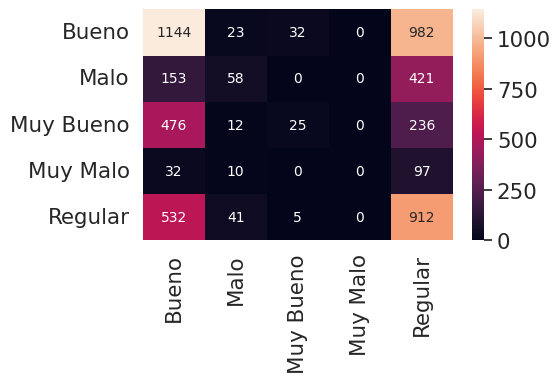

In [ ]:
# 1. CLASIFICACIÓN CON RIDGE REGRESSION:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

def calc_rating_label_array(ratings):
    """ Calculate rating labels based on an array of ratings. """
    # Divide el rango en 5 partes iguales
    bin_edges = [0, 20, 40, 60, 80, 100]
    labels = ["Muy Malo", "Malo", "Regular", "Bueno", "Muy Bueno"]
    # Asigna las etiquetas según el rango
    rating_labels = np.digitize(ratings, bins=bin_edges, right=True)
    # Ajusta el índice para obtener las etiquetas correctas del array 'labels'
    rating_labels -= 1
    # Convierte los índices en etiquetas
    rating_labels = [labels[i] for i in rating_labels]

    return rating_labels

# Create the confusion matrix
def plot_confussion_matrix(y_test, y_pred, class_names):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Plot the confusion matrix
    plt.figure(figsize = (5,3))
    sn.set(font_scale=1.4)  # for label size
    sn.heatmap(df_cm, annot=True, fmt='.0f', annot_kws={"size": 10})  # font size
    plt.show()

ridge_labels = calc_rating_label_array(predictions_ridge)
test_labels = calc_rating_label_array(y_test)
dummy_labels = calc_rating_label_array(predictions_dummy)

class_names = ["Bueno" ,"Malo", "Muy Bueno","Muy Malo","Regular" ]
print(classification_report(test_labels, ridge_labels))
plot_confussion_matrix(test_labels, ridge_labels, class_names)





In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sn

y_1 = df_descriptions['rating_label']
X_train, X_test, y_1_train, y_1_test = train_test_split(X, y_1, test_size=0.2, random_state=42)


Accuracy of Decision Tree Classifier: 0.32787516856097093
Classification Report:
              precision    recall  f1-score   support

       Bueno       0.44      0.46      0.45      2181
        Malo       0.17      0.17      0.17       632
   Muy Bueno       0.18      0.15      0.16       616
    Muy Malo       0.10      0.08      0.09       272
     Regular       0.31      0.32      0.31      1490

    accuracy                           0.33      5191
   macro avg       0.24      0.24      0.24      5191
weighted avg       0.32      0.33      0.32      5191



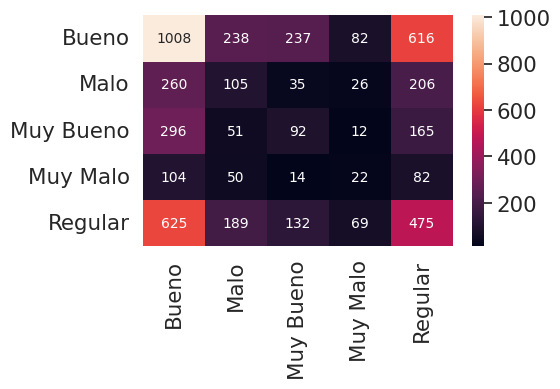

In [ ]:
# 2. Clacificación con  Decision tree
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train_tfidf, y_1_train)

# Make predictions on the test set
predictions_decision_tree = decision_tree_classifier.predict(X_test_tfidf)


# Evaluate the decision tree classifier
accuracy = accuracy_score(y_1_test, predictions_decision_tree)
print(f'Accuracy of Decision Tree Classifier: {accuracy}')

# Display the classification report
print('Classification Report:')
print(classification_report(y_1_test, predictions_decision_tree))

# Plot the confusion matrix
plot_confussion_matrix(y_1_test, predictions_decision_tree,class_names)


**Clacificación con  Decision tree**

En términos de precisión, el modelo logra un 44% para la clase "Bueno", indicando que el 44% de las instancias predichas como "Bueno" son realmente "Bueno". Sin embargo, los valores de precisión para las clases restantes son del 18%,10% y 31%, entonces se puede decir que el modelo tiene dificulatades para realizar predicciones precisas en las categorias de "Malo","Muy Malo","Muy Bueno"y "Regular".

En el caso de recall indica que el modelo identifica correctamente el 46% de todas las instancias reales de "Bueno",mientras que para la clase "Regular" identifica correctamente el 33% de la instancias. El recall es más bajo para
las otras clases, oscilando entre 7% y 17%.
F1-Score:

El F1-score es la media armónica de precision y recall. Se optienen valores similares que para recall y precisión, para las calses "Bueno" y "Regular" se obtienen valores altos como, 45% y 32% y para el resto de las clases se obtienen valores mas bajos entre 9% y 17%.

Accuracy es de aproximadamente de 33%, entonces el modelo acierta en aproximadamente el 33% de las predicciones en el conjunto de datos de prueba.

La precisión y el recall son bajos para varias clases, lo que indica que el modelo puede no estar generalizando bien a esas categorías específicas.
La accuracy es relativamente baja, lo que sugiere que el modelo no tiene un rendimiento robusto en la clasificación general.


Accuracy of k-NN Classifier: 0.2924292043922173
Classification Report for k-NN:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Bueno       0.48      0.01      0.03      2181
        Malo       0.37      0.01      0.02       632
   Muy Bueno       0.77      0.02      0.03       616
    Muy Malo       0.00      0.00      0.00       272
     Regular       0.29      0.99      0.45      1490

    accuracy                           0.29      5191
   macro avg       0.38      0.21      0.11      5191
weighted avg       0.42      0.29      0.15      5191



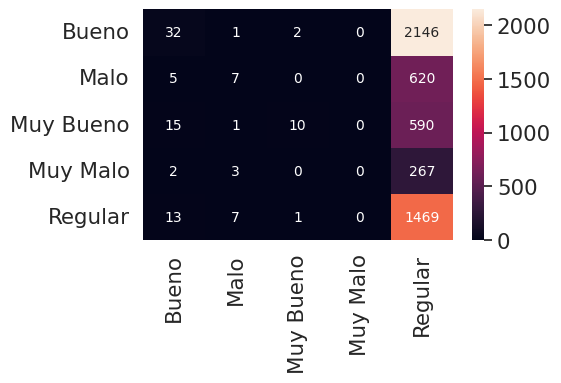

In [ ]:
# 3. Clacificación con KKN

from sklearn.neighbors import KNeighborsClassifier

kkn_classifier = KNeighborsClassifier(n_neighbors=5)
kkn_classifier.fit(X_train_tfidf, y_1_train)

# Set up the k-NN classifier and make predictions
knn_classifier = KNeighborsClassifier(n_neighbors=10)  # Ajusta el número de vecinos según sea necesario
knn_classifier.fit(X_train_tfidf, y_1_train)
predictions_knn = knn_classifier.predict(X_test_tfidf)

# Evaluate the k-NN classifier
accuracy_knn = accuracy_score(y_1_test, predictions_knn)
print(f'Accuracy of k-NN Classifier: {accuracy_knn}')

# Display the classification report for k-NN
print('Classification Report for k-NN:')
print(classification_report(y_1_test, predictions_knn))

# Plot the confusion matrix for k-NN
plot_confussion_matrix(y_1_test, predictions_knn, class_names)

Para la mayoría de las clases, la precisión y el recall son bajos. Por ejemplo, para la clase "Bueno", la precisión es del 48%, pero el recall es muy bajo (1%). Esto sugiere que el modelo tiene dificultades para identificar correctamente esta clase.
La clase "Regular" tiene una precisión más alta (29%) y un recall muy alto (99%), lo que indica que el modelo es más efectivo para predecir esta clase en comparación con otras.

La precisión global es baja, con un 29.24%, lo que indica que el modelo acierta en alrededor del 29% de las predicciones en el conjunto de datos de prueba.


Accuracy of Naive Bayes Classifier: 0.4213061067231747
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

       Bueno       0.42      1.00      0.59      2181
        Malo       0.00      0.00      0.00       632
   Muy Bueno       1.00      0.00      0.00       616
    Muy Malo       0.00      0.00      0.00       272
     Regular       0.75      0.00      0.01      1490

    accuracy                           0.42      5191
   macro avg       0.43      0.20      0.12      5191
weighted avg       0.51      0.42      0.25      5191



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


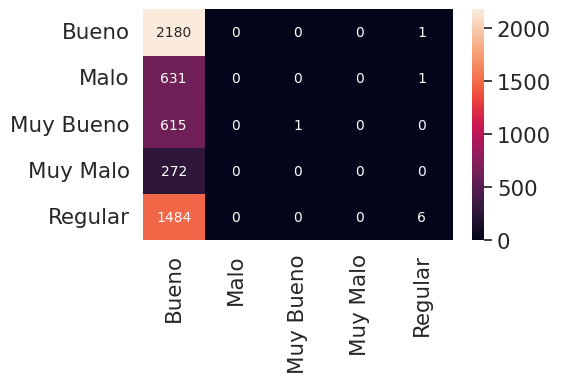

In [ ]:
# 4. Clacificación con Naive Bayes
from sklearn.naive_bayes import MultinomialNB

naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tfidf, y_1_train)


# Set up the Naive Bayes classifier and make predictions
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tfidf, y_1_train)
predictions_naive_bayes = naive_bayes_classifier.predict(X_test_tfidf)

# Evaluate the Naive Bayes classifier
accuracy_naive_bayes = accuracy_score(y_1_test, predictions_naive_bayes)
print(f'Accuracy of Naive Bayes Classifier: {accuracy_naive_bayes}')

# Display the classification report for Naive Bayes
print('Classification Report for Naive Bayes:')
print(classification_report(y_1_test, predictions_naive_bayes))

# Plot the confusion matrix for Naive Bayes
plot_confussion_matrix(y_1_test, predictions_naive_bayes, class_names)

**Clacificación con Naive Bayes**

Para la clase "Bueno", la precisión es del 42%, lo que indica que el 42% de las instancias predichas como "Bueno" son realmente "Bueno". Sin embargo, el recall es del 100%, sugiriendo que el modelo logra identificar todas las instancias reales de "Bueno". El F1-score es del 59%, indicando un equilibrio entre precisión y recall para esta clase.
Para otras clases como "Malo", "Muy Bueno", "Muy Malo", las métricas de precisión, recall y F1-score son extremadamente bajas. Esto sugiere que el modelo tiene dificultades para realizar predicciones precisas y no está capturando bien estas categorías. Para la clase "Regular", la precisión es del 75%, lo que indica que el 75% de las instancias predichas como "Regullar" son realmente "Regular". Sin embargo el recall y f1-score son muy bajos, por tanto el modelo no está capturando bien esta categoría.


La exactitud del clasificador de Naive Bayes es del 42.13%. Esto significa que aproximadamente el 42% de las predicciones son correctas en el conjunto de datos de prueba.

Accuracy of SVM Classifier: 0.4309381622038143
Classification Report for SVM:
              precision    recall  f1-score   support

       Bueno       0.46      0.80      0.58      2181
        Malo       0.34      0.04      0.07       632
   Muy Bueno       0.57      0.06      0.11       616
    Muy Malo       0.25      0.00      0.01       272
     Regular       0.35      0.29      0.32      1490

    accuracy                           0.43      5191
   macro avg       0.39      0.24      0.22      5191
weighted avg       0.41      0.43      0.36      5191



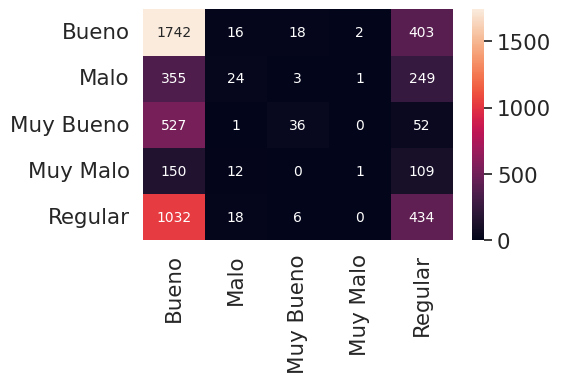

In [ ]:
# 5. Clacificación con SVM
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear', random_state=241)
svm_classifier.fit(X_train_tfidf, y_1_train)


# Set up the SVM classifier and make predictions
svm_classifier = SVC(kernel='linear', random_state=42)  # Puedes ajustar el kernel según sea necesario
svm_classifier.fit(X_train_tfidf, y_1_train)
predictions_svm = svm_classifier.predict(X_test_tfidf)

# Evaluate the SVM classifier
accuracy_svm = accuracy_score(y_1_test, predictions_svm)
print(f'Accuracy of SVM Classifier: {accuracy_svm}')

# Display the classification report for SVM
print('Classification Report for SVM:')
print(classification_report(y_1_test, predictions_svm))

# Plot the confusion matrix for SVM
plot_confussion_matrix(y_1_test, predictions_svm, class_names)

**Clacificación con SVM**

Para la clase "Bueno", la precisión es del 46%, indicando que el 46% de las instancias predichas como "Bueno" son realmente "Bueno". El recall es del 80%, sugiriendo que el modelo logra identificar el 80% de todas las instancias reales de "Bueno". El F1-score es del 58%, indicando un buen equilibrio entre precisión y recall para esta clase.
Para otras clases como "Malo", "Muy Bueno", "Muy Malo" y "Regular", las métricas de precisión, recall y F1-score son variadas. Se observa que el modelo tiene dificultades en particular para las clases minoritarias como "Muy Bueno" y "Muy Malo".

La clase "Bueno" tiene un soporte de 2181, lo que indica que hay muchas instancias de esta clase en el conjunto de datos. Para otras clases, el soporte es más bajo, destacando el desafío de la predicción en clases menos frecuentes.


La exactitud del clasificador SVM es del 43.09%, lo que significa que aproximadamente el 43% de las predicciones son correctas en el conjunto de datos de prueba.